In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cpnCommonlib import setup_figures, world_map, SDSinfo
import datetime as dtm
import xarray as xr
from pyhdf.SD import SD,SDC
import cpnCommonlib as cpn
setup_figures(plt)

In [59]:
def get_doy(year,month,day):
    return (dtm.datetime(year,month,day)-dtm.datetime(year-1,12,31)).days
def readvalue(hf,name,verbose=True):
    """
    To read MODIS values from hdf files
    """
    a=hf.select(name)
    val=np.array(a.get(),dtype=float)
    fval   = a.attributes()['_FillValue']
    scale  = a.attributes()['scale_factor']
    offset = a.attributes()['add_offset']
    val[np.where(val==fval)]=np.nan
    val = val*scale+offset
    return val
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
def map_domain():
    projection = ccrs.PlateCarree(central_longitude=0) # How to do the projection
    transform  = ccrs.PlateCarree(central_longitude=0) #How to do the tranform (How is data defined?)
    fig1,ax1 = plt.subplots(figsize=(8,3),subplot_kw={'projection':projection})
    ax1.coastlines()
    #ax1.stock_img()
    #ax1.add_feature(cfeature.OCEAN, color="skyblue", alpha=0.4)
    #ax1.add_feature(cfeature.LAND, color="lightgrey", alpha=0.5)

    #ax1.set_extent([110, 210.1, 9, 65])
    ax1.set_extent([240, 280, 19, 55])
    gl = ax1.gridlines(draw_labels=True,linestyle='--',\
                  xlocs=mticker.FixedLocator(np.arange(-120,-60,10)),ylocs=mticker.FixedLocator([10,20,30,40,50,60]))

    gl.top_labels=False
    return fig1,ax1,projection,transform,gl

In [67]:
get_doy(2018,8,31)

243

Objectives:

- To build a tool to MODIS (or ideally both MODIS and VIIRS) liquid cloud water path from groun-based ARM observations
- This tool is intended to use to validate PACE products after launched
- We should have a working code/setup, and a small technical report **by September**

## Data
### MODIS data

- MODIS MOD06L2 (Terra) data downloaded to: data/MODIS/

### ARM cloud water path

- ARM data portal https://adc.arm.gov/discovery/#/ 
- Data product that will be using: MWRRET (https://www.arm.gov/capabilities/vaps/mwrret)
    - Two channel groud-based atmospheric radiometers to retrieve precipitable water vapor (PWV) and liquid water path (LWP) Turner et. al. 2007
- We can use SGP, ENA, and NSA sites


#### References
- PACE validation plan: https://pace.oceansciences.org/docs/PACE_Validation_Plan_14July2020.pdf
- Andey's e-mail with title " Initial task - validating MODIS or VIIRS liquid water path as a proxy for eventual PACE OCI data"
- Turner et. al. 2007

In [80]:
import glob
data = {'doy':np.arange(213,244),'cwp':np.zeros_like(np.arange(213,244))+np.nan}
for i in np.arange(31):
    hdf = {}
    try:
        mo06_f = glob.glob('data/modis/MOD06_L2/MOD06_L2.A2018%02d.1735.061.?????????????.hdf'%i)[0]
        mo03_f = glob.glob('data/modis/MOD03/MOD03.A2018%02d.????.061.?????????????.hdf'%i)[0]
        hdf['mo06'] = SD(mo06_f,SDC.READ)
        hdf['mo03'] = SD(mo03_f,SDC.READ)
        cwp = readvalue(hdf['mo06'],'Cloud_Water_Path')
        lat = hdf['mo03'].select('Latitude').get()
        lon = hdf['mo03'].select('Longitude').get()
        #finding closest lat-lon
        val = cpn.haversine(-97.485,36.605,lon.reshape(-1),lat.reshape(-1))
        data['cwp'][i] = cwp.reshape(-1)[val.argmin()]
    except Exception as e:
        print("No file found!")


No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!
No file found!


In [81]:
data

{'doy': array([213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243]),
 'cwp': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan])}

In [6]:
import h5py
import pandas as pd
#f=h5py.File('data/arm/MWRRET/sgpmwrret1liljclouC1.c2.20180809.000035.nc','r')
#arm = SD('data/arm/MWRRET/sgpmwrret1liljclouC1.c2.20180801.000015.nc',SDC.READ)
#arm = xr.Dataset('data/arm/MWRRET/ascii-csv/sgpmwrret1liljclouC1.c2.20180831.000003.csv')
arm = pd.read_csv('data/arm/MWRRET/ascii-csv/sgpmwrret1liljclouC1.c2.20180801.000015.csv')

In [10]:
arm.lon.unique()

array([-97.485])

In [79]:
glob.glob('data/modis/MOD06_L2/MOD06_L2.A2018%02d.1735.061.?????????????.hdf'%i)

[]

In [56]:
COT.shape,lat.shape

((2030, 1354), (2030, 1354))

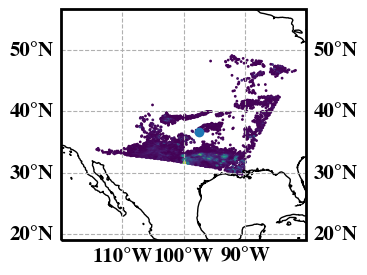

In [60]:
#fig, ax, gl, projection, transform = cpn.world_map()
fig,ax,projection,transform,gl = map_domain()
ax.scatter(lon.reshape(-1)[::100],lat.reshape(-1)[::100],c=cwp.reshape(-1)[::100],s=1)
arm_locs = {'C1':[-97.485,36.605]}
ax.scatter(*arm_locs['C1'])
val = cpn.haversine(-97.485,36.605,lon.reshape(-1),lat.reshape(-1))

In [61]:
lon.reshape(-1)[val.argmin()],lat.reshape(-1)[val.argmin()],cwp.reshape(-1)[val.argmin()]

(-97.48099, 36.601994, nan)

(array([3.42553e+05, 6.06680e+04, 2.15340e+04, 1.22300e+04, 7.66300e+03,
        4.45200e+03, 3.00100e+03, 1.90200e+03, 1.81300e+03, 1.55500e+03,
        9.33000e+02, 7.44000e+02, 3.94000e+02, 2.19000e+02, 1.32000e+02,
        6.40000e+01, 1.90000e+01, 3.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([1.00000e+00, 2.67150e+02, 5.33300e+02, 7.99450e+02, 1.06560e+03,
        1.33175e+03, 1.59790e+03, 1.86405e+03, 2.13020e+03, 2.39635e+03,
        2.66250e+03, 2.92865e+03, 3.19480e+03, 3.46095e+03, 3.72710e+03,
        3.99325e+03, 4.25940e+03, 4.52555e+03, 4.79170e+03, 5.05785e+03,
        5.32400e+03]),
 <BarContainer object of 20 artists>)

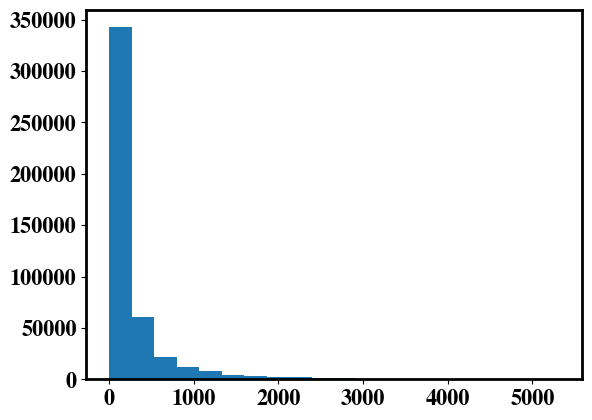

In [45]:
plt.hist(cwp.reshape(-1),bins=20)

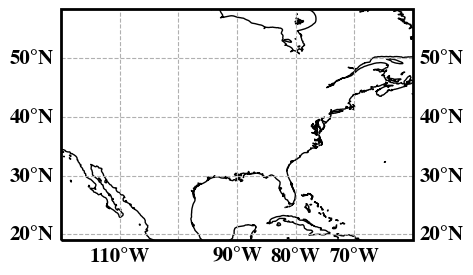

In [34]:

fig1,ax1,projection,transform,gl = map_domain()

(<Figure size 800x300 with 1 Axes>,
 <GeoAxesSubplot:>,
 <Derived Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_m ...>
 Name: unknown
 Axis Info [cartesian]:
 - E[east]: Easting (unknown)
 - N[north]: Northing (unknown)
 - h[up]: Ellipsoidal height (metre)
 Area of Use:
 - undefined
 Coordinate Operation:
 - name: unknown
 - method: Equidistant Cylindrical
 Datum: unknown
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Derived Projected CRS: +proj=eqc +ellps=WGS84 +a=6378137.0 +lon_0=0 +to_m ...>
 Name: unknown
 Axis Info [cartesian]:
 - E[east]: Easting (unknown)
 - N[north]: Northing (unknown)
 - h[up]: Ellipsoidal height (metre)
 Area of Use:
 - undefined
 Coordinate Operation:
 - name: unknown
 - method: Equidistant Cylindrical
 Datum: unknown
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <cartopy.mpl.gridliner.Gridliner at 0x7fd43c1c52e0>)

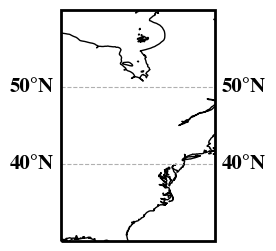

In [18]:
map_domain()

In [49]:
cpn.SDSinfo('/Users/crajapak/pace/oci_cloud_validations/data/MOD06_L2/Y2018/MOD03/MOD03/2018/213/MOD03.A2018213.0000.061.2018213080654.hdf','MOD03')

Attempting filename: /Users/crajapak/pace/oci_cloud_validations/data/MOD06_L2/Y2018/MOD03/MOD03/2018/213/MOD03.A2018213.0000.061.2018213080654.hdf
MOD03.info SAVED!!
MOD03meta.info SAVED!!
